In [1]:
from aiohttp import web
import socketio

import os
import base64
from io import BytesIO
import json
import jsonpickle

import cv2
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

import glob
import re
import copy

from gel_tools import GelAnalysis

# Multiple Segmentation Map Viewer

In [12]:
# Choose folder
gel_image_folder = 'C:/Users/asus/Desktop/2022 Summer Intern/Gel Electrophoresis Data Project Summer 2021/nathan_gels/Q_1/raw'  # make sure that the segmentation map filenames are identical to image filenames or this won't work!
segmentation_folder = 'C:/Users/asus/Desktop/2022 Summer Intern/Gel Electrophoresis Data Project Summer 2021/nathan_gels/Q_1/segmentation'

# set foreground/background colour
foreground_colour = (255,0,0)
background_colour = (0,255,0)

In [13]:
def extract_image_names_from_folder(folder, sorted=True, recursive=False):
    filenames = []
    for extension in ['*.jpg', '*.png', '*.bmp', '*.tif']:
        if recursive:
            glob_path = os.path.join(folder, '**', extension)
        else:
            glob_path = os.path.join(folder, extension)
        filenames.extend(glob.glob(glob_path, recursive=recursive))
    if sorted:
        # Sort file names in Natural Order so that numbers starting with 1s don't take priority
        filenames.sort(key=lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)])
    return filenames

def load_segmentation_maps_and_images(gel_image_folder, segmentation_map_folder):
    images = []

    # gets original images
    gel_files = extract_image_names_from_folder(gel_image_folder, sorted=True, recursive=True)
    
    image_names = [os.path.basename(file).split('.')[0] for file in gel_files]  # gets image names by splitting off file extension e.g. .tif 
    
    # gets segmentation maps
    segmentation_map_files = extract_image_names_from_folder(segmentation_map_folder, sorted=True, recursive=True)
        
    data_dict = {}  # prepares dictionary to collect all required info
    
    for gel_file, seg_file, image_name in zip(gel_files, segmentation_map_files, image_names):
        
        gel_img = cv2.imread(gel_file)  # read images
        seg_img = cv2.imread(seg_file)
        
        # np.all = finds elements in array where condition is met, the axis argument (-1 = final dimension i.e. number 2) is telling the system to confirm a match when all three elements match the target colour.
        seg_img[np.all(seg_img == (1,1,1), axis=-1)] = foreground_colour  # replacing foreground in segmentation map

        seg_img[np.all(seg_img == (2,2,2), axis=-1)] = background_colour  # replacing background in segmentation map

        data_dict[image_name] = [gel_img, seg_img]  # packaging data into dictionary (the key is the image title)
    
    return data_dict

In [14]:
data_dict = load_segmentation_maps_and_images(gel_image_folder, segmentation_folder)

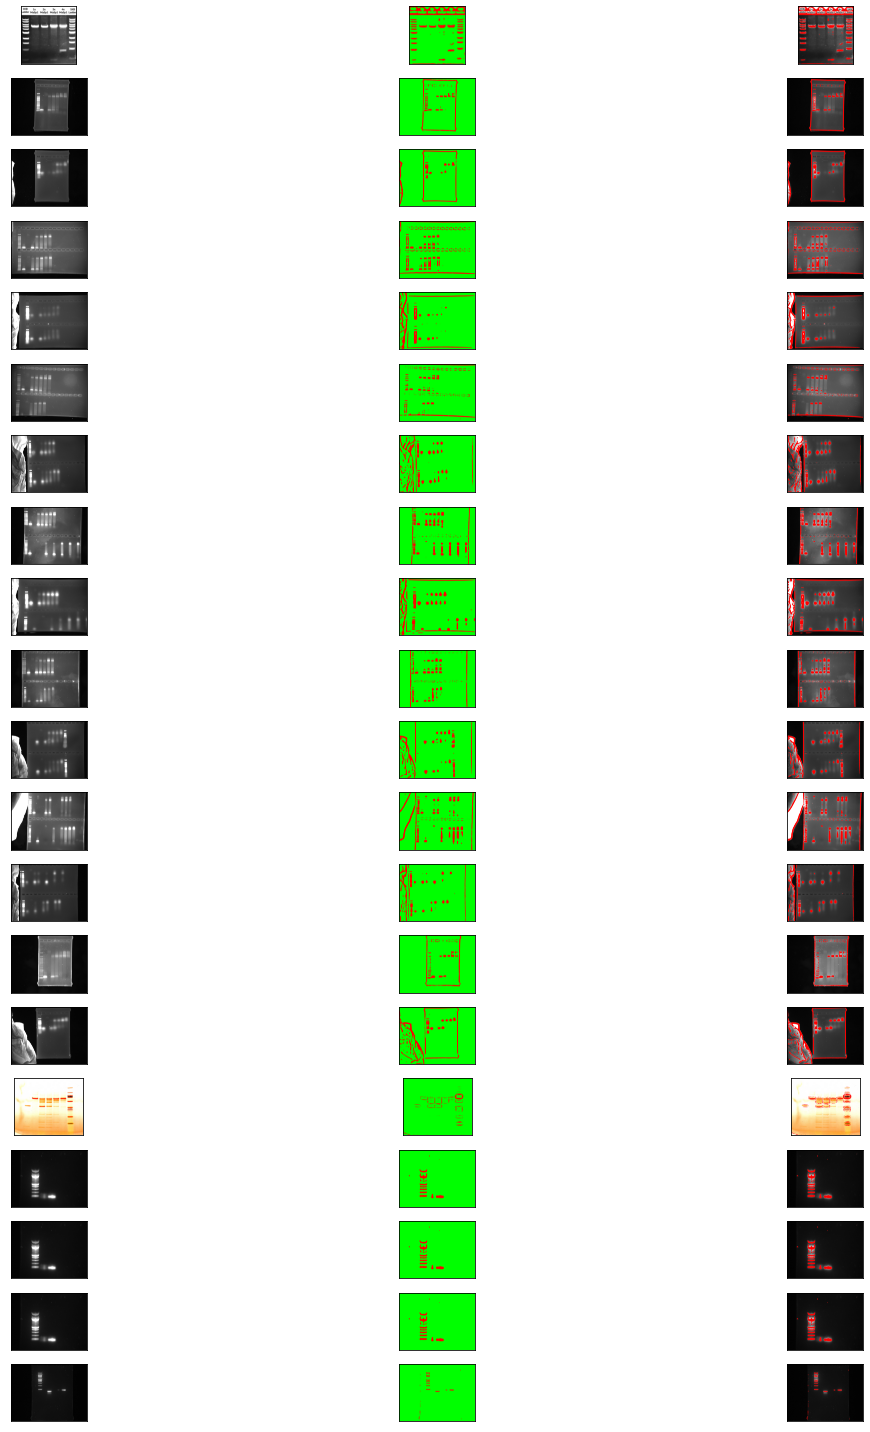

In [15]:
fig, axs = plt.subplots(len(data_dict), 3,figsize=(20,20)) # this figsize should be enough.

fontsize = 18  # title fonts

for index, (image_name, data) in enumerate(data_dict.items()):
    
    # original image in column 1
    axs[index, 0].imshow(data[0])
    # axs[index,0].set_title('Image %s' % image_name, fontsize=fontsize)
    axs[index,0].axes.xaxis.set_visible(False)
    axs[index,0].axes.yaxis.set_visible(False)
    
    # segmented image in column 2
    axs[index,1].imshow(data[1]) # , aspect='auto'
    # axs[index,1].set_title('Segmentation map for image %s' % image_name, fontsize=fontsize)
    axs[index,1].axes.xaxis.set_visible(False)
    axs[index,1].axes.yaxis.set_visible(False)
    
    # combined segmentation map + image
    
    combi_map = copy.copy(data[0])  # if this is not done, value inside dictionary will be directly modified
    
    combi_map[np.all(data[1] == foreground_colour, axis=-1)] = foreground_colour 

    axs[index,2].imshow(combi_map) # , aspect='auto'
    # axs[index,2].set_title('Image %s with foreground highlighted' % image_name, fontsize=fontsize)
    axs[index,2].axes.xaxis.set_visible(False)
    axs[index,2].axes.yaxis.set_visible(False)
    
fig.tight_layout()  # helps even out spacing between images and fills up all available space

In [8]:
fig.savefig('/Users/matt/Desktop/tst.pdf')  # save to pdf as this will ensure a good output.  Later, we might use pngs if pdfs are not suitable.